# Lorenz-System

### Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import rcdefaults
rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = [12.8, 7.2]
plt.rcParams["font.size"] = 12
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"] = 0.75
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["legend.edgecolor"] = "white"

### Numerical Methods

In [2]:
def rk4(f, y0, t0, tN, N):
    '''
    Returns list of function values approximated with the Runge-Kutta method of 4th order.

    f .... function of ODE y' = f(y, t)
    y0 ... initial value y(t0) = y0
    t0 ... start of interval
    tN ... end of interval
    N .... number of steps
    '''
    
    h = (tN - t0) / N
    t = t0 + h * np.arange(N+1)
    
    y = np.zeros(N+1) if isinstance(y0, (int, float)) else np.zeros((N+1, y0.size))
    y[0] = y0
    
    for n in range(N):
        k1 = f(y[n], t[n])
        k2 = f(y[n] + h/2 * k1, t[n] + h/2)
        k3 = f(y[n] + h/2 * k2, t[n] + h/2)
        k4 = f(y[n] + h * k3, t[n] + h)
        y[n+1] = y[n] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    return y

In [3]:
def adams_bashforth(f, y0, t0, tN, N, order=4, inits=None):
    '''
    Returns list of function values approximated with the Adams-Bashforth method.

    f ....... function of ODE y' = f(y, t)
    inits ... initial values (y0, ...)
    t0 ...... start of interval
    tN ...... end of interval
    N ....... number of steps
    order ... order of method
    inits ... inital values after y0 up to order
    '''
    
    h = (tN - t0) / N
    t = t0 + h * np.arange(N+1)
    
    koeffs = (1,
              [-1/2, 3/2],
              [5/12, -16/12, 23/12],
              [-9/24, 37/24, -59/24, 55/24],
              [251/720, -1274/720, 2616/720, -2774/720, 1901/720])
    
    y = np.zeros(N+1) if isinstance(y0, (int, float)) else np.zeros((N+1, y0.size))
    y[0] = y0
    
    fn = np.zeros(N+1) if isinstance(y0, (int, float)) else np.zeros((N+1, y0.size))
    fn[0] = f(y0, t0)
    
    s = order-1 if 1 <= order <= 4 else 3
    
    if s > 0:
        if inits is None or len(inits) != s:
            inits = rk4(f, y0, t0, t0+h*s, s)[1][1:]
        for i in range(s):
            y[i+1] = inits[i]
            fn[i+1] = f(y[i+1], t[i+1])
        
    for n in range(N-s):
        y[n+s+1] = y[n+s] + h * np.dot(koeffs[s], fn[n:n+s+1])
        fn[n+s+1] = f(y[n+s+1], t[n+s+1])
    
    return y

In [4]:
def ABE(f, y0, t0, tN, N, order=4, inits=None):
    '''
    Returns list of function values approximated with the predictor-corrector method using Adams-Moulton and Adams-Bashforth.

    f ....... function of ODE y' = f(y, t)
    y0 ...... initial value y(t0) = y0
    t0 ...... start of interval
    tN ...... end of interval
    N ....... number of steps
    order ... order of method
    inits ... optional initial values after y0 up to order
    '''
    
    h = (tN - t0) / N
    t = t0 + h * np.arange(N+1)
    
    coeffs = ([1/2, 1/2],
              [-1/12, 2/3, 5/12],
              [1/24, -5/24, 19/24, 9/24],
              [-19/720, 106/720, -264/720, 646/720, 251/720])
    
    y = np.zeros(N+1) if isinstance(y0, (int, float)) else np.zeros((N+1, y0.size))
    y[0] = y0
        
    fn = np.zeros(N+1) if isinstance(y0, (int, float)) else np.zeros((N+1, y0.size))
    fn[0] = f(y0, t0)
        
    s = order-1 if 1 <= order <= 4 else 3
    
    if s > 0:
        if inits is None or len(inits) != s:
            inits = rk4(f, y0, t0, t0+h*s, s)[1:]
        for i in range(s):
            y[i+1] = inits[i]
            fn[i+1] = f(y[i+1], t[i+1])
    
    yp = y
    fp = fn
    
    for n in range(N-s):
        # predictor: adams bashforth
        yp[n+s+1] = adams_bashforth(f, y[n], t[n], t[n+s+1], s+1, order=s+1, inits=y[n+1:n+s+1])[-1]
        
        # evaluation
        fp[n+s+1] = f(yp[n+s+1], t[n+s+1])
        
        # corrector: adams moulton
        y[n+s+1] = y[n+s] + h * np.dot(coeffs[s][0:-1], fn[n:n+s+1]) + h * coeffs[s][-1] * fp[n+s+1]
        
        #evaluation
        fn[n+s+1] = f(y[n+s+1], t[n+s+1])
        
    return y

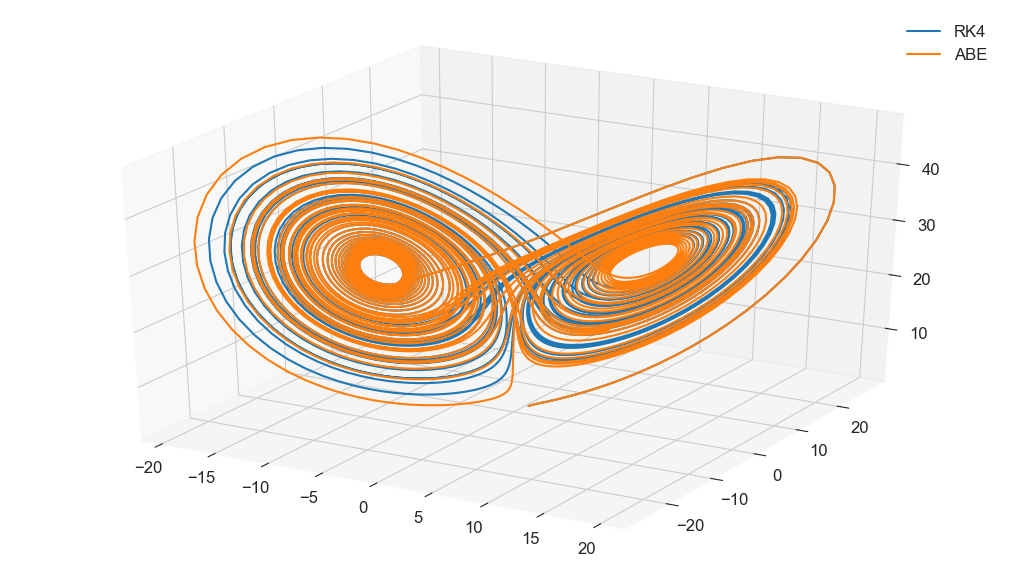

In [5]:
rho = 28
sigma = 10
beta = 8 / 3

def f(state, t):
    x, y, z = state
    return np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z])

state0 = np.array([1, 1, 1])
t0 = 0
tN = 50
N = 5000

states_rk4 = rk4(f, state0, t0, tN, N)
states_ABE = ABE(f, state0, t0, tN, N)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states_rk4[:, 0], states_rk4[:, 1], states_rk4[:, 2], label="RK4")
ax.plot(states_ABE[:, 0], states_ABE[:, 1], states_ABE[:, 2], label="ABE")
plt.legend()
plt.show()